In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import camb
from camb import model, initialpower
from matplotlib.font_manager import FontProperties
from scipy import integrate
from scipy import special
from scipy import signal, interpolate
from numba import jit
import constnumberfile as cn
import functionfile as ff
import CAMBPS
import MHexample as MH
import sys; sys.path.append('..')
from MHexample import vari as MHvari
import subprocess
import itertools
#subprocess.run(['jupyter', 'nbconvert', '--to', 'python', 'UCMH.ipynb'])

Note: redshifts have been re-sorted (earliest first)
0
10
(20, 16) (21,) (20, 16)


In [2]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=70.4, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0);
pars.set_matter_power(redshifts=[20], kmax=1e2)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-2, maxkh=1e2, npoints = 100)
s8 = np.array(results.get_sigma8())
print(s8)

[0.0503693]


In [3]:
def powertrans(k,Am):    
    up=(cn.omrad/cn.om)**2*Am
    Ck=4*np.sqrt(cn.omrad)*k*cn.c0/(np.sqrt(3)*cn.H0m*cn.om)
    down=81*(-(7/2)+0.577+np.log(Ck))**2
    Acurvature=up/down
    return Acurvature

In [4]:
ndpk=pk*(kh[None,:]**3/(2*np.pi**2))
k=kh*cn.h
kh0=np.logspace(-3,5,1000)
f1 = interpolate.interp1d(k, ndpk,fill_value="extrapolate")
y1 = f1(kh0)
def PS(k):
    y1=f1(k)
    return y1

In [5]:
zmin=10
#zlist=np.arange(zmin,40+1,20)      
#zlist=np.linspace(10,30,100)
zlist=np.array([20])
#zclist=np.logspace(np.log10(50),np.log10(1e5),100) 
kmin=ff.kvir(20,1e4)
#kmin=10
#kmin=1e2
kmax=900
dk=200
klist=np.logspace(np.log10(kmin),np.log10(kmax),dk)
#klist=np.array([300,700])
dxy=30
J=5
k01=np.logspace(-J,0,dxy)
k02=np.logspace(0,-J,dxy)
k05=np.hstack((-k02,[0],k01))
k06=np.hstack(([0],k01))
Ac=np.logspace(-2,-8,2000)
#Ac=np.array([1*1e-6,4*1e-6,4*1e-7])
Am=ff.powertrans(klist,Ac)
kp=np.logspace(-3,3,200)
Wcy=ff.Wcy(zlist,kp,cn.Dnu)
varisigma=ff.variUCMH(zlist,kp,PS(kp).transpose(1,0),Wcy)
def dzclist(zcmin):
    zclist=np.logspace(np.log10(zcmin),np.log10(1e5),50)
    return zclist

In [6]:
@jit ('f8(f8[:],f8[:],f8[:],f8[:],f8[:],f8,f8,f8[:],f8,f8)')
def Tbavec(klist,zclist,zlist,k05,k06,A0,B0,Am,NM,ex):
    Rv=np.zeros((len(klist),len(zclist),len(zlist)))
    TGasave=np.zeros((len(klist),len(zclist),len(zlist)))
    TBav=np.zeros((len(klist),len(zclist),len(zlist)))
    Mv=np.zeros((len(klist),len(zclist),len(zlist)))
    dTb=np.zeros((len(klist),len(zlist),len(Am[0])))
    #biasw=np.zeros((len(klist),len(zlist),len(Am)))
    BdTb=np.zeros((len(klist),len(zlist),len(Am[0])))
    #dbias=np.zeros((len(klist),len(zclist),len(zlist),len(Am)))
    for i,kk in enumerate(klist):
        for k,z in enumerate(zlist):
            for j,zc in enumerate(zclist):
                if (zc>4000):
                    zc=4000
                c,rv,mv,tg0,Tgasave,Rgasave,Tbav=ff.singleUCMH(k05,k05,z,zc,kk,A0,B0,k06,0,NM,ex)
                #if(i%10==0 and j%1==0):
                    #print(c,Rgasave)
                #if (tg0>1e4):
                    #Tbav=ff.Tcmb(z)
                Rv[i,j,k]=rv
                TGasave[i,j,k]=Tgasave
                TBav[i,j,k]=Tbav
                Mv[i,j,k]=mv
            DTb,DdTb=ff.diffTbave(z,zclist,Rv[i,:,k],TGasave[i,:,k],TBav[i,:,k],Am[i,:],kk)
            Dbias=ff.dbiasPT(Am[i,:],zclist)
            biasW,bb=ff.wbUCMH(Dbias,DdTb,zclist)
            dTb[i,k]=DTb
            BdTb[i,k]=bb
            #biasw[i,k]=biasW
            #dbias[i,:,k,:]=Dbias
        if(i%50==0):
            print(i)
    return  dTb,BdTb,Mv

In [7]:
def up(klist,zlist,Am,UCMHsignal):
    Amm=np.zeros(UCMHsignal.shape)
    for i,kk in enumerate(klist):
        for j,z in enumerate(zlist):
            for k,am in enumerate(Am[i,:]):
                for l in range(2):
                    if(UCMHsignal[i,j,k,l]-IGMsignal[i,j,k,l]>0):
                        Amm[i,j,k,l]=am
                    else:
                        UCMHsignal[i,j,k,l]=0
    return UCMHsignal,Amm

In [8]:
def upperlimt(Acmax,klist):
    Acupper=np.zeros((len(klist)))
    Aclower=np.zeros((len(klist)))
    klistz=np.zeros((len(klist)))
    I=[]
    for i,kk in enumerate(klist):
        if(all(Acmax[i,0,:,0] == 0)):
            continue
        else:
            Acupper[i]=np.min((Acmax[i,0,:,0])[ Acmax[i,0,:,0] > 0])
            Aclower[i]=np.max((Acmax[i,0,:,0])[ Acmax[i,0,:,0] > 0])
            klistz=klist
            I+=[i]
    Acupper=Acupper[I[0]:I[-1]]
    Aclower=Aclower[I[0]:I[-1]]
    klistz=klistz[I[0]:I[-1]]
    return Acupper,Aclower,klistz

In [9]:
#for i,NM in enumerate(['N','M']):
for i,NM in enumerate(['M']):
    if(i==0):
        rd=200
    else:
        rd=200
    for j,dzc in enumerate([50]):
        exec("dTb%s%s,BdTb%s%s,Mv%s%s=Tbavec(klist,dzclist(dzc),zlist,k05,k06,30, rd ,Am,i,0)"%(NM,dzc,NM,dzc,NM,dzc))

/Users/kokoorikunihiko/Desktop/python/UCMH21cmpublishver/functionfile.py:218: RuntimeWarning: divide by zero encountered in true_divide
  dF=(t/F)*(dg*h1+g*dh1+dh2)
/Users/kokoorikunihiko/Desktop/python/UCMH21cmpublishver/functionfile.py:269: RuntimeWarning: invalid value encountered in multiply
  bdTb=integrate.simps(bias*ddTb,zc[:,None],axis=0)


0
50
100


/Users/kokoorikunihiko/Desktop/python/UCMH21cmpublishver/functionfile.py:218: RuntimeWarning: invalid value encountered in multiply
  dF=(t/F)*(dg*h1+g*dh1+dh2)


150


In [10]:
#for i,NM in enumerate(['N','M']):
for i,NM in enumerate(['M']):
    for i,dzc in enumerate([50]):
        exec("variTb%s%s=varisigma[None,:,None,:]*BdTb%s%s[:,:,:,None]"%(NM,dzc,NM,dzc))
        exec("UCMHsignal%s%s=abs(variTb%s%s)"%(NM,dzc,NM,dzc))
        exec("IGMsignal=abs(MHvari(zlist))[None,:,None,:]*np.ones((UCMHsignal%s%d.shape))"%(NM,dzc))
        exec("sigmax%s%s,Ammax%s%s=up(klist,zlist,Am,UCMHsignal%s%s)"%(NM,dzc,NM,dzc,NM,dzc))
        exec("Acmax%s%d=abs(powertrans(klist[:,None,None,None],Ammax%s%d))"%(NM,dzc,NM,dzc))
        exec("Acupper%s%d,Aclower%s%d,klistz%s%d=upperlimt(Acmax%s%d,klist)"%(NM,dzc,NM,dzc,NM,dzc,NM,dzc))

In [51]:
AcupperM50[44]=4*1e-0
AcupperN50[44]=4*1e-0
AcupperM50[45:50]=1e-0
AcupperN50[45:50]=1e-0

In [140]:
AcupperM50[170:175]
AcupperM50[172:-1]=1
AcupperN50[172:-1]=1

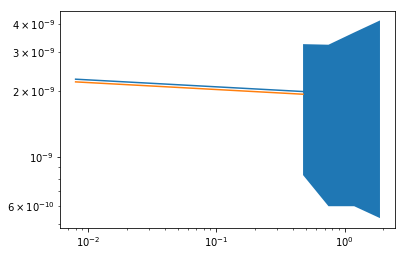

In [13]:
#bird 2011 lyman constraint
lyak=np.array([0.475,0.75,1.19,1.89])
lyapcup=np.array([3.25,3.23,3.67,4.16])*1e-9
lyapcdown=np.array([0.83,0.60,0.60,0.53])*1e-9
kcmb=np.linspace(0.008,0.475,100)
ks=0.05
ns=np.array([0.9641+0.0044,0.9641-0.0044])
As=np.array([np.exp(3.044+0.014)*1e-10,np.exp(3.044-0.014)*1e-10])
cmbpc=As[None,:,None]*(kcmb[:,None,None]/ks)**(ns[None,None,:]-1)
#plt.loglog(lyak,lyapcup)
#plt.plot(lyak,lyapcdown)
plt.fill_between(lyak,lyapcup,lyapcdown)
plt.loglog(kcmb,cmbpc[:,0,0])
plt.plot(kcmb,cmbpc[:,1,0])

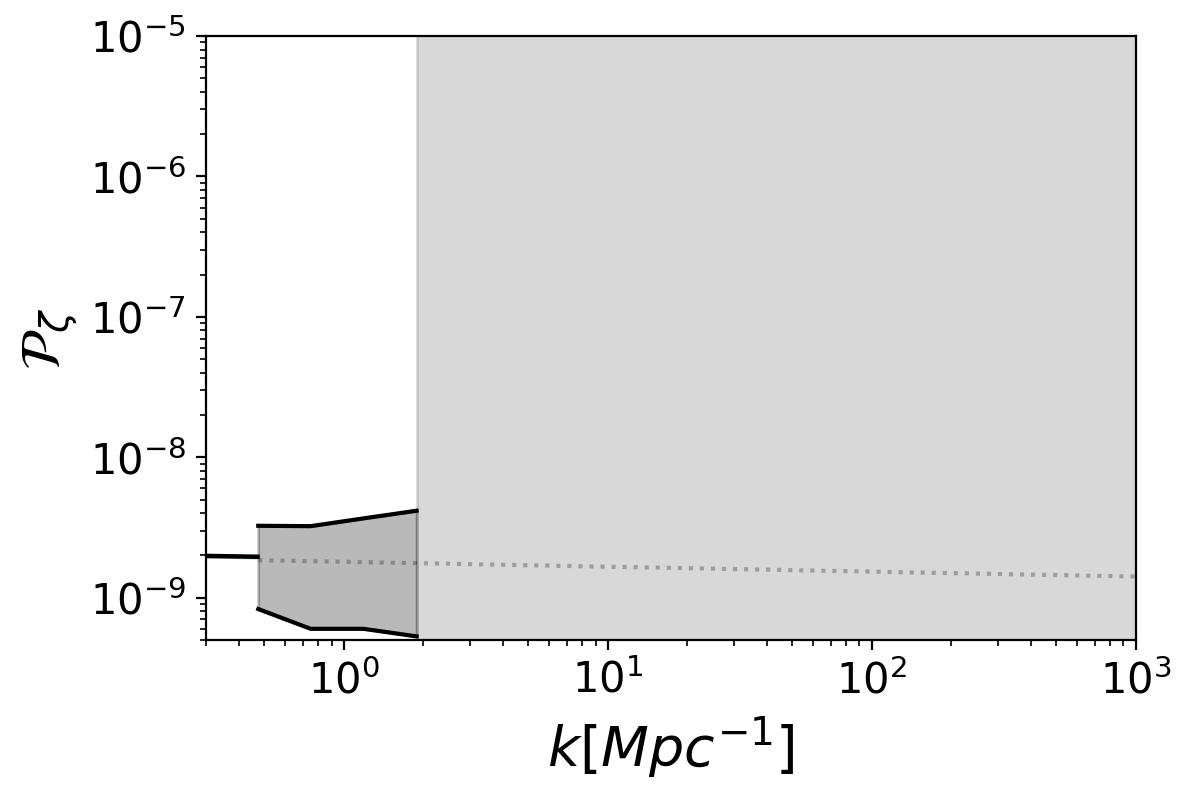

In [27]:
plt.figure(figsize=(6, 4), dpi=200)
sig=1.5*1e1
kx=np.linspace(0.80*1e3,1.20*1e3)
k=np.linspace(lyak[0],1e6)
#plt.loglog(kx,(5*1e-7/(np.sqrt(2*np.pi*sig)))*np.exp(-(kx-1e3)**2/(2*sig**2))+results.Params.scalar_power(kx),color='black')
plt.loglog(k,results.Params.scalar_power(k),color='0.1',alpha=0.3,ls='dotted')
plt.fill_betweenx([1e-10,1e-4],lyak[-1],1e4,color='0.5',alpha=0.3)
#plt.fill_betweenx([1e-10,1e-4],klistzM50[167],1e8,color='green',alpha=0.3)
plt.fill_between(lyak,lyapcup,lyapcdown,color='0.1',alpha=0.3)
plt.fill_between(kcmb,cmbpc[:,0,0],cmbpc[:,1,0],color='green',alpha=0.3)
#plt.fill_between(klistzM50[0:167],1e-10,AcupperM50[0:167],color='green',alpha=0.3)
plt.loglog(lyak,lyapcup,color='black')
plt.plot(lyak,lyapcdown,color='black')
#for i,NM in enumerate(['M']):
    #for j,dzc in enumerate([50]):
        #='solid'
        #exec("plt.semilogy(klistz%s%d[0:167],Acupper%s%d[0:167],color='black',ls=linestyles[j],label=r'$z_{c,min}$=%d')"%(NM,dzc,NM,dzc,dzc))
plt.loglog(kcmb,cmbpc[:,0,0],color='black',linewidth=1)
plt.plot(kcmb,cmbpc[:,1,0],color='black',linewidth=1)
plt.ylim(5*1e-10,1e-5)
plt.ylabel(r'$\mathcal{P}_{\zeta} $',size=20)
plt.xlabel('$k [Mpc^{-1}]$',size=20)
plt.tick_params(labelsize=15)
plt.xlim(3*1e-1,1e3)
plt.savefig('/Users/kokoorikunihiko/Desktop/学振書類new/figs/power0.pdf',bbox_inches='tight' ,dpi=300)

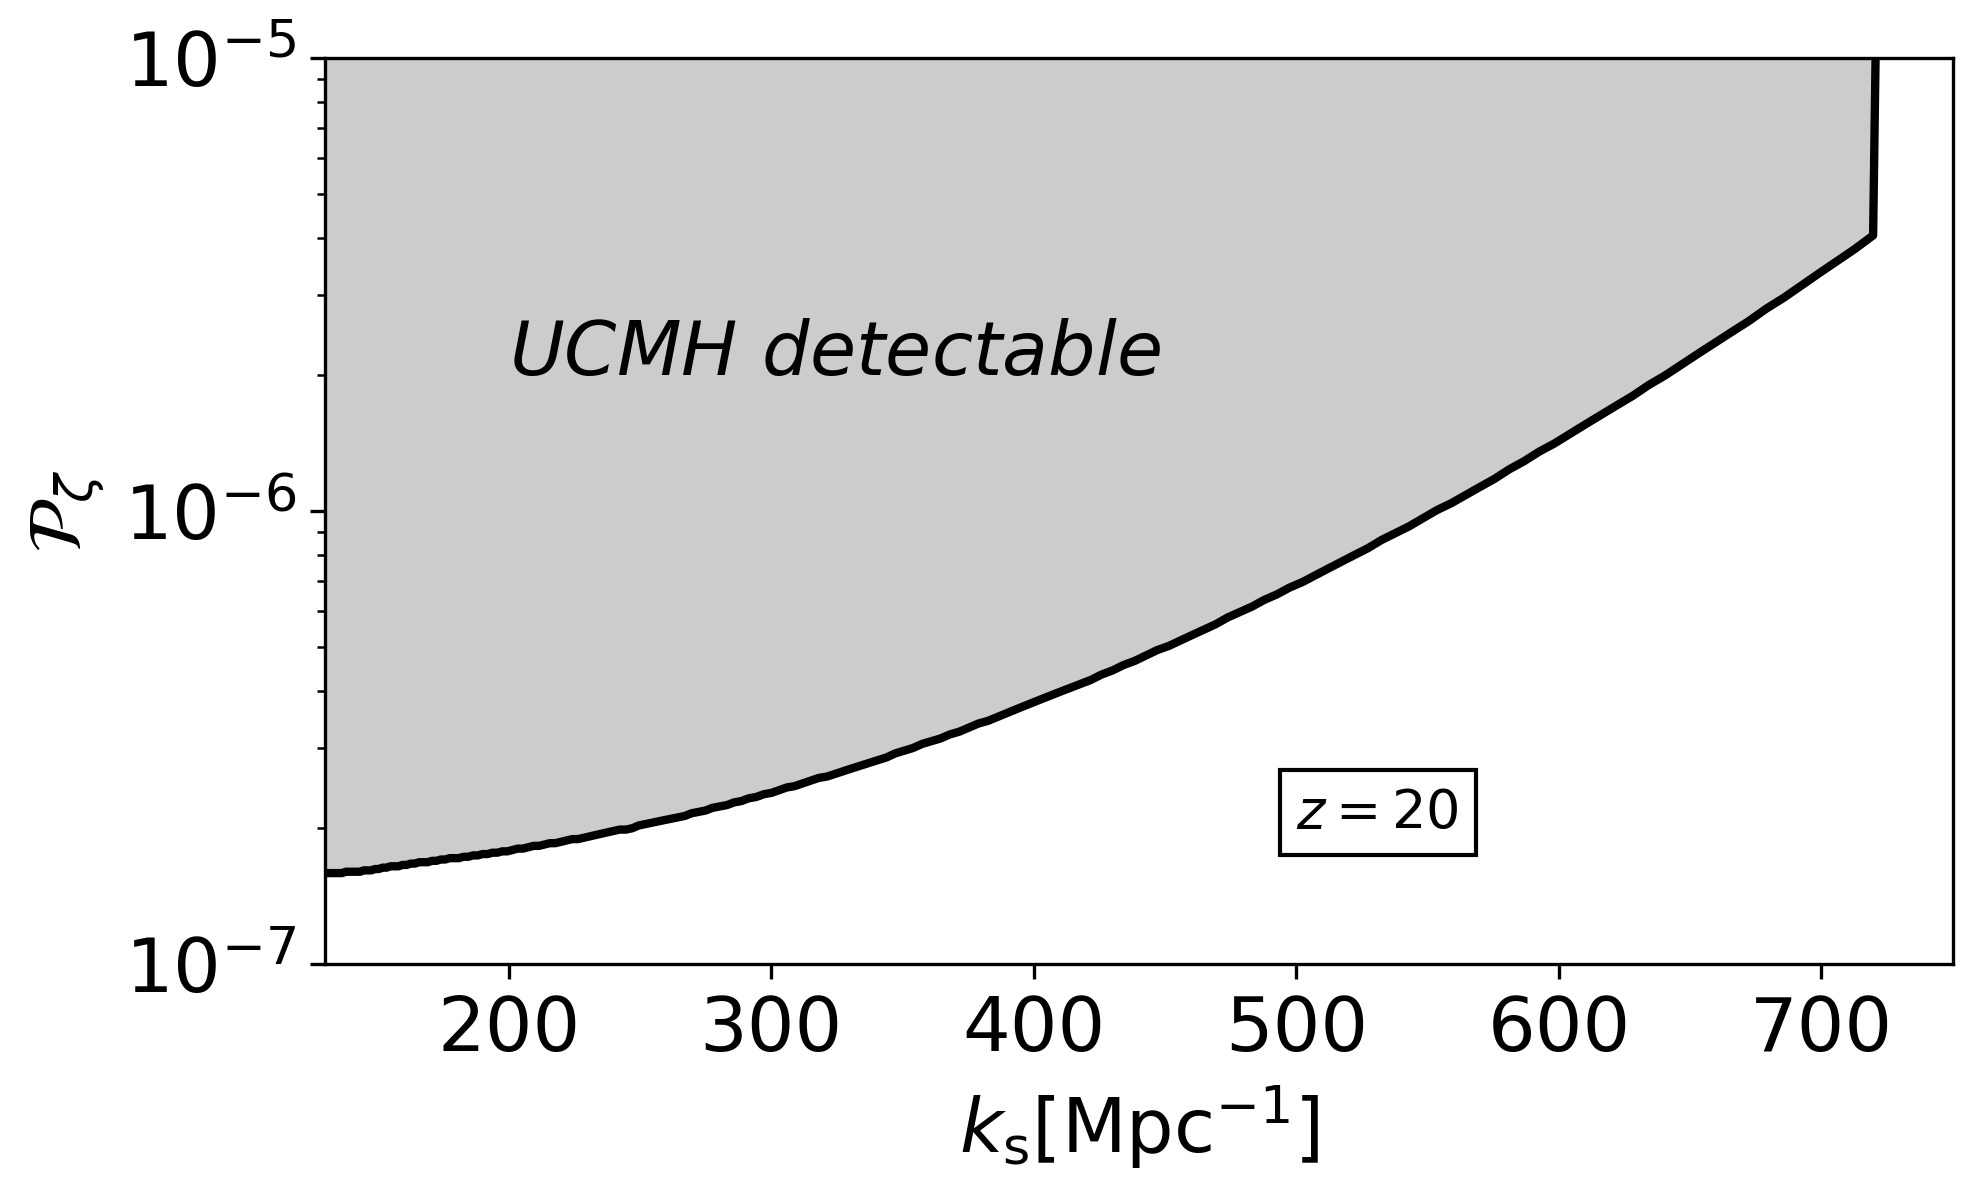

In [16]:
plt.figure(figsize=(7, 4), dpi=300)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
linestyles = ['-', '--', '-.', ':']
i=178
#for i in range(len(Am)):
    #plt.scatter(klist,abs(powertrans(klist[:,None,None,None],AmmaxM200))[:,0,i,0],s=6,color='blue',alpha=0.3)
plt.semilogy(klistzM50[0:i],AcupperM50[0:i],color='black',linewidth='2')
#plt.semilogy(klistzN50[0:i],AcupperN50[0:i],color='blue',ls='dotted')
plt.fill_between(klistzM50[0:i], AcupperM50[0:i],AclowerM50[0:i],color='0.8')
#plt.fill_between(klistzM200, AclowerM200,1e3,color='green',alpha=0.3)
#plt.fill_betweenx([1e-8,1e-2],klistzM50[-1],2000,color='red',alpha=0.3)
#plt.fill_between(klistzM50, AcupperM50,0,color='red',alpha=0.3)
#plt.fill_betweenx([1e-8,1e-3],10,ff.kvir(20,1e4),color='green',alpha=0.3)
#plt.set_xscale('log')
#plt.yscale('log')
plt.ylim(1e-7,1e-5)
plt.xlim(klistzM50[0],750)
#print(klistzM50[93])
plt.tick_params(labelsize=18)
#plt.ylabel(r'$\mathcal{A}_{\zeta}$',size=15)
plt.ylabel(r'$\mathcal{P}_{\zeta}$',size=18)
plt.xlabel(r'$k_{\rm s} [{\rm Mpc^{-1}}]$',size=18)
plt.text(500,2*1e-7,r'$z=20$',size=13 , bbox=dict(facecolor='white', alpha=1.0))
#plt.text(150,8*1e-7,'NFW profile',size=15,color='blue')
#plt.text(550,5*1e-7,'Moore profile',size=15,color='black')
#plt.text(700,2*1e-8,r'$z_{c,min}=100$',size=13 ,  bbox=dict(facecolor='white', alpha=1.0))
plt.text(200,2*1e-6,r'$UCMH \ detectable $',size=18)
#plt.text(200,2*1e-8,r'$other \ dominant \ region$',size=18)
#plt.text(10,2*1e-3,r'$T_{\rm{vir}}>10^4$',size=15)
plt.savefig('/Users/kokoorikunihiko/Desktop/学振書類new/figs/powerconstraint.pdf',bbox_inches='tight' ,dpi=300)

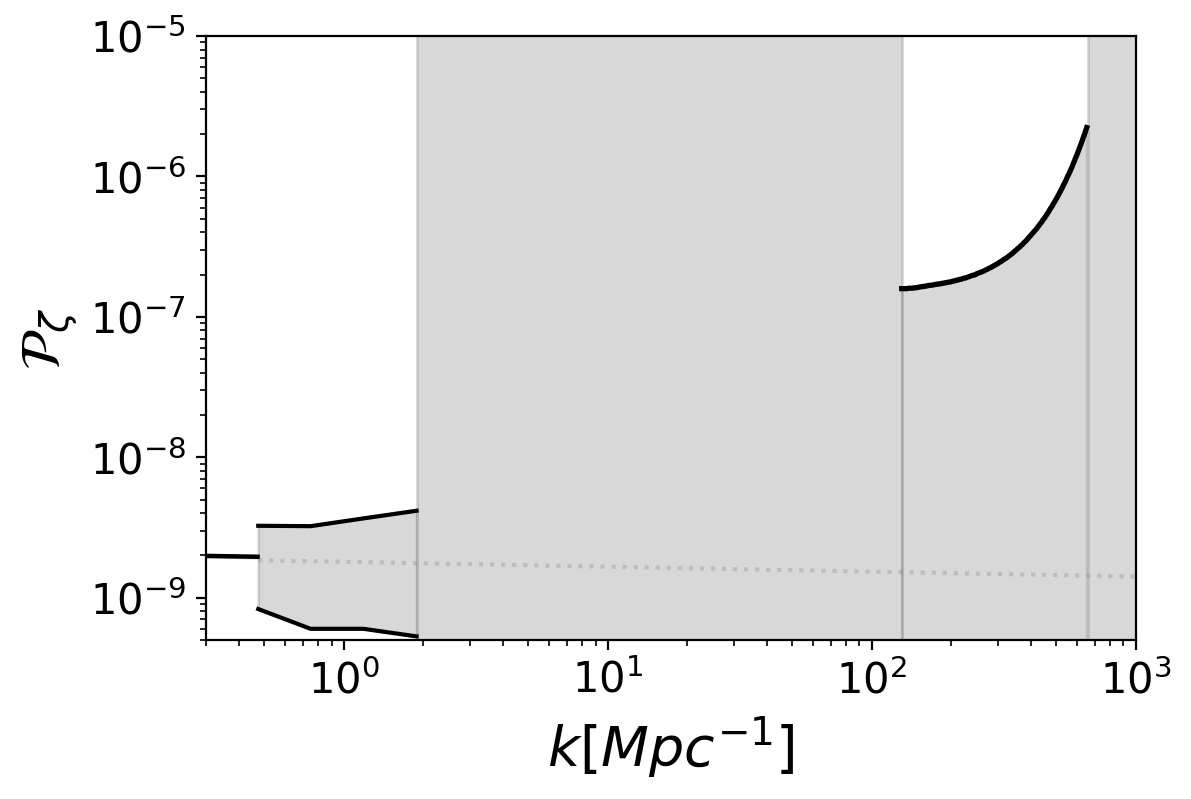

In [44]:
#plt.loglog(k,primoridal_PK)
plt.figure(figsize=(6, 4), dpi=200)
sig=1.5*1e1
kx=np.linspace(0.80*1e3,1.20*1e3)
k=np.linspace(lyak[0],1e6)
#plt.loglog(kx,(5*1e-7/(np.sqrt(2*np.pi*sig)))*np.exp(-(kx-1e3)**2/(2*sig**2))+results.Params.scalar_power(kx),color='black')
plt.loglog(k,results.Params.scalar_power(k),color='0.5',alpha=0.3,ls='dotted')
plt.fill_betweenx([1e-10,1e-4],lyak[-1],klistzM50[0],color='0.5',alpha=0.3)
plt.fill_betweenx([1e-10,1e-4],klistzM50[167],1e8,color='0.5',alpha=0.3)
plt.fill_between(lyak,lyapcup,lyapcdown,color='0.5',alpha=0.3)
plt.fill_between(kcmb,cmbpc[:,0,0],cmbpc[:,1,0],color='0.5',alpha=0.3)
plt.fill_between(klistzM50[0:167],1e-10,AcupperM50[0:167],color='0.5',alpha=0.3)
plt.loglog(lyak,lyapcup,color='black')
plt.plot(lyak,lyapcdown,color='black')
for i,NM in enumerate(['M']):
    for j,dzc in enumerate([50]):
        l='solid'
        exec("plt.semilogy(klistz%s%d[0:167],Acupper%s%d[0:167],color='black',ls=linestyles[j],linewidth=1.9,label=r'$z_{c,min}$=%d')"%(NM,dzc,NM,dzc,dzc))
plt.loglog(kcmb,cmbpc[:,0,0],color='black',linewidth=1)
plt.plot(kcmb,cmbpc[:,1,0],color='black',linewidth=1)
plt.ylim(5*1e-10,1e-5)
plt.ylabel(r'$\mathcal{P}_{\zeta}$',size=20)
plt.xlabel('$k [Mpc^{-1}]$',size=20)
plt.tick_params(labelsize=15)
plt.xlim(3*1e-1,1e3)
#np.save('/Users/kokoorikunihiko/Desktop/python/UCMHlensing/result/21-cmconstraintAcup.npy',AcupperM50[0:167])
#np.save('/Users/kokoorikunihiko/Desktop/python/UCMHlensing/result/21-cmconstraintkslist.npy',klistzM50[0:167])
plt.savefig('/Users/kokoorikunihiko/Desktop/学振書類new/figs/power1.pdf',bbox_inches='tight' ,dpi=300)